<a href="https://colab.research.google.com/github/mohsenfaghih13/AOD/blob/main/02_pinn_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Total Loss: 0.325583 | MSE: 1.04e-01 | Rel. MSE: 1.03e+00
Epoch 200, Total Loss: 0.141672 | MSE: 4.74e-02 | Rel. MSE: 4.72e-01
Epoch 400, Total Loss: 0.089506 | MSE: 3.13e-02 | Rel. MSE: 3.12e-01
Epoch 600, Total Loss: 0.044263 | MSE: 6.34e-02 | Rel. MSE: 6.31e-01
Epoch 800, Total Loss: 0.041141 | MSE: 6.36e-02 | Rel. MSE: 6.33e-01
Epoch 1000, Total Loss: 0.040320 | MSE: 6.33e-02 | Rel. MSE: 6.30e-01
Epoch 1200, Total Loss: 0.039767 | MSE: 6.34e-02 | Rel. MSE: 6.31e-01
Epoch 1400, Total Loss: 0.039398 | MSE: 6.33e-02 | Rel. MSE: 6.31e-01
Epoch 1600, Total Loss: 0.039173 | MSE: 6.30e-02 | Rel. MSE: 6.27e-01
Epoch 1800, Total Loss: 0.039017 | MSE: 6.26e-02 | Rel. MSE: 6.24e-01


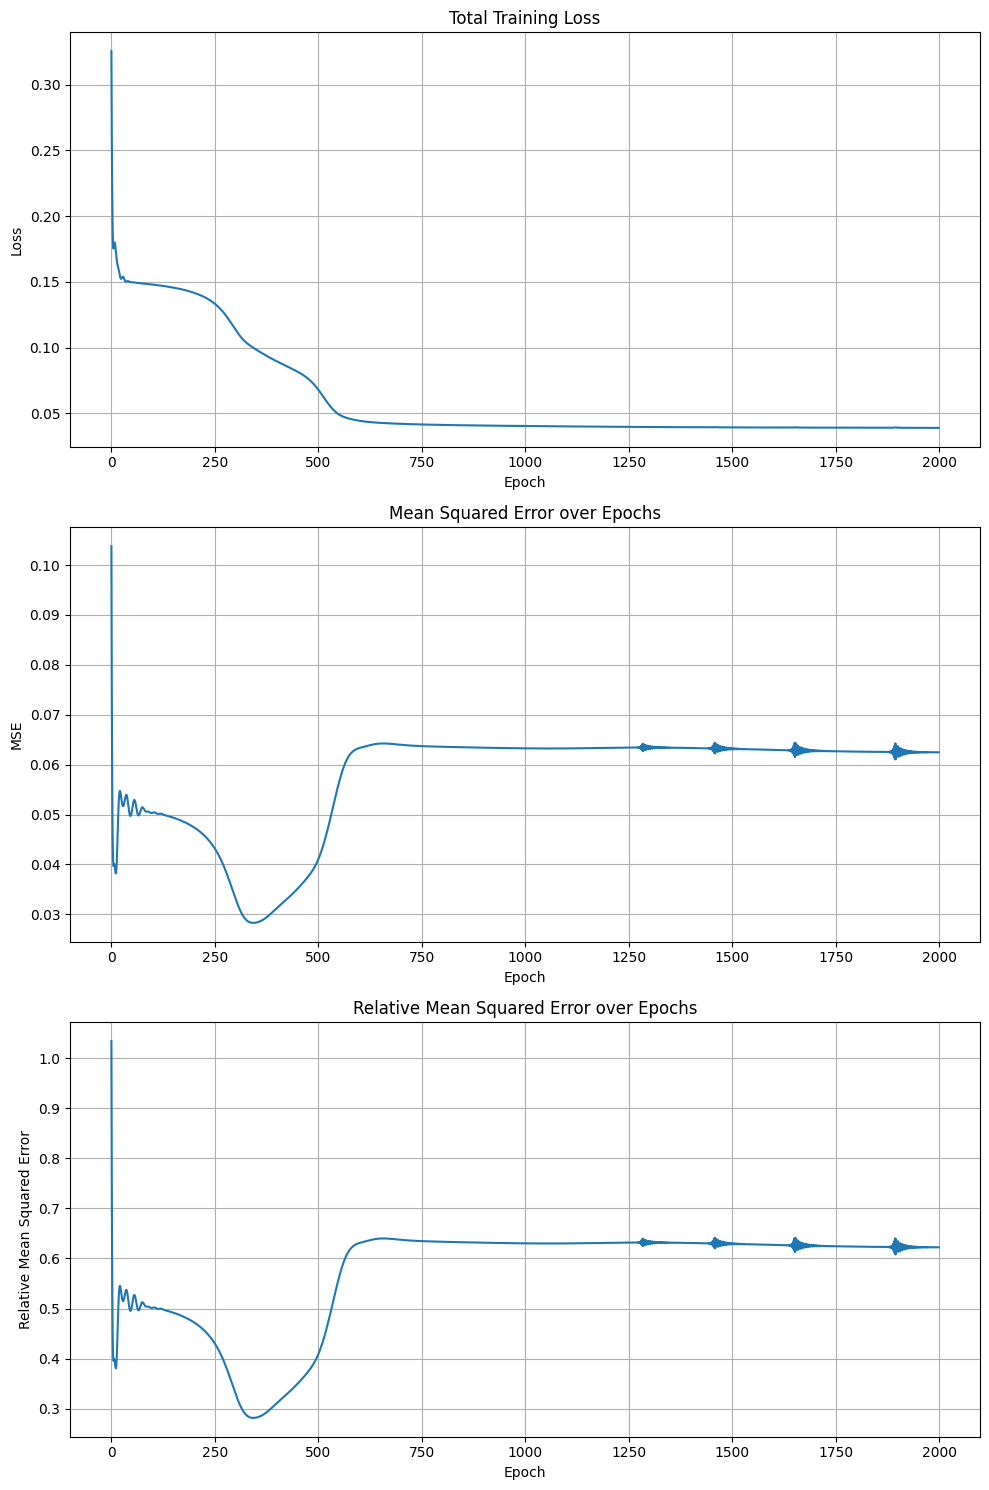

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np

# A "fake" true solution
def true_solution(x, y, t):
    return torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(-t)

# 1. Define PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, xyt):
        return self.net(xyt)

# 2. Compute derivatives using autograd
def derivatives(u, xyt):
    grad_u = autograd.grad(u, xyt, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]
    u_t = grad_u[:, 2:3]

    u_xx = autograd.grad(u_x, xyt, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]
    u_yy = autograd.grad(u_y, xyt, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]

    return u_t, u_x, u_y, u_xx, u_yy

# 3. PDE residual
def pde_residual(model, xyt, vx=1.0, vy=0.5, D=0.01):
    u = model(xyt)
    u_t, u_x, u_y, u_xx, u_yy = derivatives(u, xyt)
    return u_t + vx * u_x + vy * u_y - D * (u_xx + u_yy)

# 4. Generate training and evaluation data
def gen_data(Nf=1000, Nic=200, Nbc=200, N_eval=500):
    def rand_xy(N):
        x = torch.rand(N, 1)
        y = torch.rand(N, 1)
        return x, y
    def rand_t(N):
        return torch.rand(N, 1)
    def zeros_t(N):
        return torch.zeros(N, 1)

    # Training data for physics and boundary conditions
    xf, yf = rand_xy(Nf)
    tf = rand_t(Nf)
    xyt_f = torch.cat([xf, yf, tf], dim=1).requires_grad_()
    x0, y0 = rand_xy(Nic)
    t0 = zeros_t(Nic)
    xyt_ic = torch.cat([x0, y0, t0], dim=1).requires_grad_()
    u_ic = torch.sin(torch.pi * x0) * torch.sin(torch.pi * y0)
    tb = rand_t(Nbc)
    y_b1 = torch.rand(Nbc, 1)
    bc1 = torch.cat([torch.zeros(Nbc, 1), y_b1, tb], dim=1)
    bc2 = torch.cat([torch.ones(Nbc, 1), y_b1, tb], dim=1)
    x_b2 = torch.rand(Nbc, 1)
    bc3 = torch.cat([x_b2, torch.zeros(Nbc, 1), tb], dim=1)
    bc4 = torch.cat([x_b2, torch.ones(Nbc, 1), tb], dim=1)
    xyt_bc = torch.cat([bc1, bc2, bc3, bc4], dim=0).requires_grad_()

    # Data points for calculating MSE and REL during training
    xe, ye = rand_xy(N_eval)
    te = rand_t(N_eval)
    xyt_eval = torch.cat([xe, ye, te], dim=1).requires_grad_()
    u_eval = true_solution(xe, ye, te)

    return xyt_f, xyt_ic, u_ic, xyt_bc, xyt_eval, u_eval

# 5. Training
model = PINN()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

xyt_f, xyt_ic, u_ic, xyt_bc, xyt_eval, u_eval = gen_data(N_eval=500)

loss_log = []
mse_log = []
rel_log = []

for epoch in range(2000):
    opt.zero_grad()

    # Physics-based loss
    f = pde_residual(model, xyt_f)
    loss_pde = (f**2).mean()
    u_pred_ic = model(xyt_ic)
    u_pred_bc = model(xyt_bc)
    loss_ic = ((u_pred_ic - u_ic)**2).mean()
    loss_bc = (u_pred_bc**2).mean()

    # Total loss
    loss = loss_pde + loss_ic + loss_bc
    loss.backward()
    opt.step()

    # Calculate and log
    with torch.no_grad():
        u_pred_eval = model(xyt_eval)

        # Calculate MSE
        point_square_error = torch.square(u_eval - u_pred_eval)
        current_mse = torch.mean(point_square_error).item()

        # Calculate Relative Mean Squared
        mean_square_true = torch.mean(torch.square(u_eval)).item()
        current_rel = current_mse / mean_square_true

    loss_log.append(loss.item())
    mse_log.append(current_mse)
    rel_log.append(current_rel)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Total Loss: {loss.item():.6f} | MSE: {current_mse:.2e} | Rel. MSE: {current_rel:.2e}")

# 6. Plot all metrics
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

# Plot Total Loss
ax1.plot(loss_log)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Total Training Loss")
ax1.grid(True)

# Plot Mean Squared Error (MSE)
ax2.plot(mse_log)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MSE")
ax2.set_title("Mean Squared Error over Epochs")
ax2.grid(True)

# Plot Relative Mean Squared Error (Rel. MSE)
ax3.plot(rel_log)
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Relative Mean Squared Error")
ax3.set_title("Relative Mean Squared Error over Epochs")
ax3.grid(True)

plt.tight_layout()
plt.show()